In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import random
import cv2

images1 = np.load("cs475_project_data/images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width) #reshape
labels1 = np.load("cs475_project_data/labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor) # make sure int values

images = images.type(torch.DoubleTensor)
images = (images - torch.mean(images))/torch.std(images)
# the above normalizes the data based on z score

#mirror flip
#i = np.random.choice(images.shape[0], size=10000, replace=False)
#new_temp = images.numpy()
#new_temp[i] = cv2.flip(new_temp[i], 1)
#new_temp = torch.from_numpy(new_temp)
#images = new_temp.type(torch.DoubleTensor)

# translation
#i = np.random.choice(images.shape[0], size=2000, replace=False)
#new_temp = images.numpy()
#M = np.float32([[1,0,np.random.randint(-5, high=5)],[0,1,np.random.randint(-5, high=5)]])
#new_temp[i] = cv2.warpAffine(new_temp[i],M,(new_temp[i].shape[1],new_temp[i].shape[0]))
#new_temp = torch.from_numpy(new_temp)
#images = new_temp.type(torch.DoubleTensor)

#rotation
#i = np.random.choice(images.shape[0], size=2000, replace=False)
#new_temp = images.numpy()
#new_temp[i] = cv2.warpAffine(new_temp[i],cv2.getRotationMatrix2D((new_temp[i].shape[1],new_temp[i].shape[0]),np.random.randint(-10, high=10),1),(new_temp[i].shape[1],new_temp[i].shape[0]))
#new_temp = torch.from_numpy(new_temp)
#images = new_temp.type(torch.DoubleTensor)

#scaling
#i = np.random.choice(images.shape[0], size=2000, replace=False)
#new_temp = images.numpy()
#new_temp[i] = cv2.resize(new_temp[i],None,fx=np.random.uniform(.7, 1.3), fy=np.random.uniform(.7, 1.3), interpolation = cv2.INTER_CUBIC)
#new_temp = torch.from_numpy(new_temp)
#images = new_temp.type(torch.DoubleTensor)

# split data
train_data = images[:45000]
dev_data = images[45000:]
#test_data = images[45000:]

train_labels = labels[:45000]
dev_labels = labels[45000:]
#test_labels = labels[45000:]

HEIGHT = 26
WIDTH = 26
NUM_CLASSES = 5
NUM_OPT_STEPS = 4500

### THE BELOW CELLS ARE MY FIRST BEST MODEL

In [8]:
class ConvNN(torch.nn.Module):
    def __init__(self): # best is 1 32 64 5 stride=2, 1 and kernel=6
        super().__init__() #best is 1, 15, 30, 60, 30, 5 stride=2 .004 (93% on val), 100
        self.conv1 = torch.nn.Conv2d(1, 40, kernel_size=6, stride=2) #next best 1, 12, 24, 48, 5, .003 --> 92 val
        self.conv2 = torch.nn.Conv2d(40, 80, kernel_size=6, stride=1)
        #self.conv3 = torch.nn.Conv2d(80, 40, kernel_size=6, stride=2)
        self.final_conv = torch.nn.Conv2d(80, 5, kernel_size=1)
    def forward(self, x):
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, training=True)
        x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        #x = F.relu(self.conv4(x)).clamp(min=0)
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [9]:
model = ConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=.003)

In [10]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [11]:
def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [12]:
train_accs, val_accs = [], []
iterations = []
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.37  0.34
   100  0.83  0.82
   200  0.85  0.85
   300  0.88  0.87
   400  0.89  0.89
   500  0.90  0.89
   600  0.90  0.88
   700  0.89  0.88
   800  0.92  0.91
   900  0.88  0.90
  1000  0.91  0.91
  1100  0.91  0.92
  1200  0.92  0.92
  1300  0.92  0.91
  1400  0.91  0.91
  1500  0.93  0.92
  1600  0.91  0.91
  1700  0.94  0.92
  1800  0.94  0.93
  1900  0.94  0.92
  2000  0.93  0.92
  2100  0.92  0.93
  2200  0.94  0.93
  2300  0.93  0.93
  2400  0.93  0.93
  2500  0.94  0.92
  2600  0.95  0.93
  2700  0.94  0.92
  2800  0.94  0.93
  2900  0.94  0.93
  3000  0.93  0.91
  3100  0.95  0.93
  3200  0.94  0.93
  3300  0.94  0.93
  3400  0.94  0.94
  3500  0.96  0.93
  3600  0.93  0.92
  3700  0.96  0.94
  3800  0.95  0.94
  3900  0.95  0.93
  4000  0.95  0.93
  4100  0.96  0.94
  4200  0.95  0.94
  4300  0.96  0.93
  4400  0.95  0.94


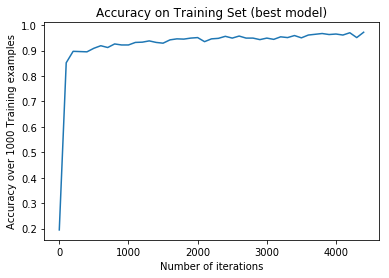

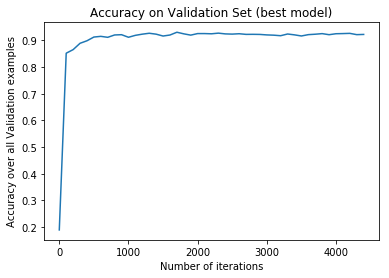

In [29]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set (best model)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set (best model)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

### THE NEXT MODEL IS MY SECOND BEST MODEL

In [2]:
class ConvNN(torch.nn.Module):
    def __init__(self): 
        super().__init__() #best is 1, 15, 30, 60, 30, 5 stride=2 .004 (93% on val), 100
        self.conv1 = torch.nn.Conv2d(1, 15, kernel_size=3, stride=2) #next best 1, 12, 24, 48, 5, .003 --> 92 val
        self.conv2 = torch.nn.Conv2d(15, 30, kernel_size=3, stride=2)
        self.conv3 = torch.nn.Conv2d(30, 60, kernel_size=3, stride=2)
        self.conv4 = torch.nn.Conv2d(60, 30, kernel_size=3, stride=2)
        self.final_conv = torch.nn.Conv2d(30, 5, kernel_size=1)
    def forward(self, x):
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, training=True)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [3]:
model = ConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=.003)

In [4]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]


def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [5]:
train_accs, val_accs = [], []
iterations = []
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.19  0.19
   100  0.79  0.82
   200  0.86  0.87
   300  0.89  0.88
   400  0.88  0.89
   500  0.90  0.90
   600  0.90  0.89
   700  0.92  0.91
   800  0.91  0.91
   900  0.93  0.91
  1000  0.92  0.92
  1100  0.93  0.91
  1200  0.93  0.92
  1300  0.94  0.92
  1400  0.93  0.92
  1500  0.93  0.92
  1600  0.94  0.93
  1700  0.93  0.92
  1800  0.94  0.92
  1900  0.95  0.92
  2000  0.94  0.92
  2100  0.92  0.91
  2200  0.95  0.92
  2300  0.95  0.93
  2400  0.94  0.92
  2500  0.95  0.92
  2600  0.94  0.93
  2700  0.96  0.92
  2800  0.95  0.92
  2900  0.95  0.92
  3000  0.96  0.92
  3100  0.95  0.92
  3200  0.96  0.92
  3300  0.96  0.93
  3400  0.96  0.92
  3500  0.95  0.92
  3600  0.96  0.92
  3700  0.96  0.92
  3800  0.97  0.92
  3900  0.97  0.92
  4000  0.96  0.92
  4100  0.97  0.92
  4200  0.96  0.92
  4300  0.96  0.92
  4400  0.96  0.92


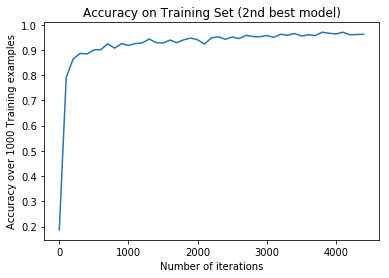

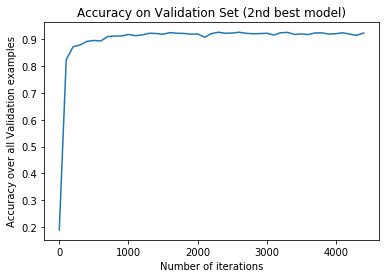

In [6]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set (2nd best model)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set (2nd best model)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

### Below is my TYPICAL model configuration

In [8]:
class ConvNN(torch.nn.Module):
    def __init__(self): 
        super().__init__() #best is 1, 15, 30, 60, 30, 5 stride=2 .004 (93% on val), 100
        self.conv1 = torch.nn.Conv2d(1, 15, kernel_size=3, stride=2) #next best 1, 12, 24, 48, 5, .003 --> 92 val
        self.conv2 = torch.nn.Conv2d(15, 30, kernel_size=3, stride=2)
        self.final_conv = torch.nn.Conv2d(30, 5, kernel_size=1)
    def forward(self, x):
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        #x = F.dropout(x, training=True)
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
    
model = ConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=.001)

def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [9]:
train_accs, val_accs = [], []
iterations = []
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.21  0.20
   100  0.48  0.49
   200  0.65  0.65
   300  0.65  0.70
   400  0.72  0.70
   500  0.71  0.72
   600  0.75  0.73
   700  0.77  0.75
   800  0.77  0.76
   900  0.75  0.76
  1000  0.75  0.77
  1100  0.78  0.78
  1200  0.76  0.78
  1300  0.76  0.78
  1400  0.76  0.78
  1500  0.76  0.76
  1600  0.78  0.79
  1700  0.77  0.80
  1800  0.79  0.80
  1900  0.78  0.79
  2000  0.81  0.81
  2100  0.78  0.81
  2200  0.81  0.81
  2300  0.81  0.81
  2400  0.78  0.80
  2500  0.82  0.82
  2600  0.81  0.82
  2700  0.82  0.82
  2800  0.79  0.82
  2900  0.80  0.82
  3000  0.79  0.82
  3100  0.82  0.82
  3200  0.80  0.82
  3300  0.81  0.82
  3400  0.83  0.83
  3500  0.84  0.83
  3600  0.82  0.83
  3700  0.83  0.83
  3800  0.83  0.83
  3900  0.82  0.83
  4000  0.84  0.83
  4100  0.83  0.84
  4200  0.82  0.83
  4300  0.83  0.84
  4400  0.83  0.83


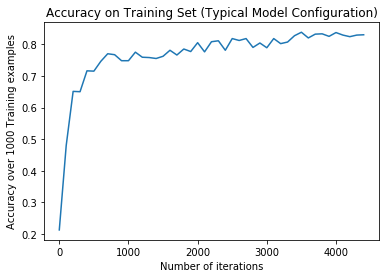

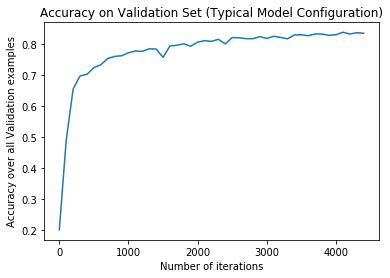

In [10]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set (Typical Model Configuration)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set (Typical Model Configuration)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

In [ ]:
# This creates the Kaggle submission
more_images = np.load("cs475_project_data/part_2_test_images.npy")
num_images, height, width = more_images.shape
more_images = more_images.reshape(num_images, height*width) # reshape
more_images = torch.from_numpy(more_images).type(torch.DoubleTensor)
more_images = more_images.type(torch.DoubleTensor)
more_images = (more_images - torch.mean(more_images))/torch.std(more_images)
csv = open("output.csv", "w") # output file
firstrow = "id,label\n" # headers
csv.write(firstrow)
more_images = more_images.numpy()
for i in range(more_images.shape[0]):
    x = autograd.Variable(torch.from_numpy(more_images[i].astype(np.float32)))
    y = model(x)
    y = y.data.numpy()
    y = np.argmax(y, axis=1)
    if (y == 0):
        csv.write(str(i) + ",0\n")
    elif (y == 1):
        csv.write(str(i) + ",1\n")
    elif (y == 2):
        csv.write(str(i) + ",2\n")
    elif (y == 3):
        csv.write(str(i) + ",3\n")
    elif (y == 4):
        csv.write(str(i) + ",4\n")


### Here are my notes on my different models' performance. 

###### 1) Initial model: 3 layer convolutional NN from conv-nn-experiments
###### 2) Varying Optimizer:

Adam: 91%, SGD: 86%, Adadelta: 91%, ASGD: 86%

Conclusion: Adam/Adadelta are the most competitive
###### 3) Mini-batch sizes: adjusted mini-batch size with inverse relationship between batch-size and # opt steps (*using Adam as optimizer*)

batch-size=10 & steps=10000: 91%, batch-size=50 & steps=8000: 91%, batch-size=100 & steps=5000: 92%

Conclusion: higher batch-size (100) and lower opt_steps (<= 5000) better for my model

###### 4) Learning rate:

lr=.01: 91%, lr=.001: 92%, lr=.002:92%, lr=.005: 92%

Conclusion: Learning rate of ~.003 is best

###### 5) Adding more layers/adjusting conv NN structure:

Added one layer with channels like so: 1-->15-->30-->60-->30-->5. This gave an accuract of 93%, the highest I have gotten so far. If I try to add more layers, the Kernel fails (probably something to do with too much memory usage?). Also, changing the stride to 2 helped make the higher accuracy values more consistent. Furthermore, more channels helped more than less channels. 

Edit: Reducing the layers to 1-->40-->80-->5 with a kernel of 6 also helped. I received 94% on validation with this (which is the highest I have gotten)

###### 6) Dropout:

Adding dropout with most probabilities hindered my model from even breaking 90% accuracy. Thus I will not use it in my final model configuration probably.


### Here is final paragraph and summary

I started creating my model with the 3-layer convolutional NN from a previous section. To begin my edits to my model, I started in the order described in my notes above. I first edited the optimizer, and found that Adam and Adadelta were very comparable (so I settled on using Adam because we discussed this already in previous homeworks). I then started to adjust the mini-batch sizes and optimal steps, and found that larger batch sizes (~100) didn't result in as much overfitting as I thought and actually trained my model better than smaller batch sizes, and at a relatively decent speed as well too. I then fiddled with the learning rate to find an optimal learning rate of around .003, but the learning rate did not affect the model's performance too much since Adam is relatively invariant to changes in the learning rate. Finally, I adjusted the model itself, by changing the number of layers and filters, adding a linear layer at the end, changing the stride of certain layers, the kernel size, and trying to clamp certain layers. I found two main configuration that led to my best performance (the code of these is above). Some adjustments I had to make:

    1) increasing the stride to make the model faster
    2) keeping the batch size at a reasonable size to make the model faster
    3) changing the kernel size to 6 in my best model since it increased validation accuracy by about 1.5%
    4) early stopping for the sake of time and overfitting
    5) increasing the number of channels in the layers

Training was too slow for a lot of my experimentation. I already mentioned some of the techniques I used to circumvent this problem, but they include the following: early stopping, adjusting the mini-batch size, changing the stride length (increasing it), and changing the number of optimal steps.

The most important changes for getting high accuracy were:

    1) increasing the stride to 2 for some layers
    2) increasing the number of channels in the layers I had
    3) changing the kernel size to 6
   
Description of final model: My final, best model has 3 layers, with number of channels described as the following sequence: 1 to 40 to 80 to 5. The kernel size is 6 except for the last layer (which is 1), and the stride of the first layer is 2 while the stride of the second is 1. The learning rate = .003, optimal steps = 5000, and batch-size = 100. Essentially, when an image is passed through the model, there are 40 filters passed through the image (each with a 6 by 6 channel except the last one), and then 80 in the next layer, and then back to 5 output channels. 

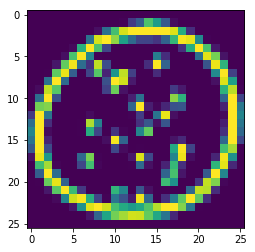

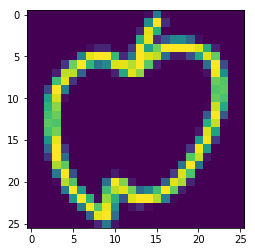

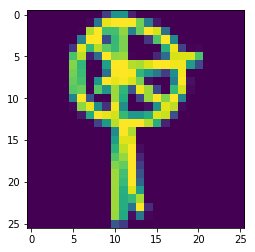

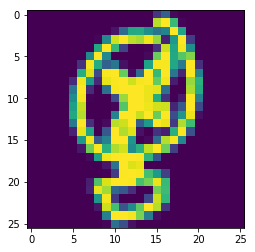

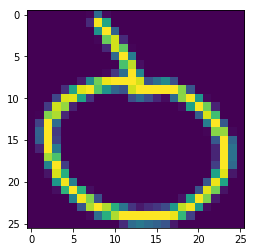

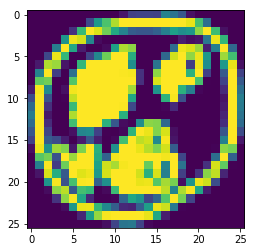

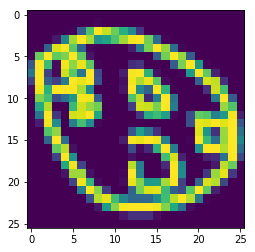

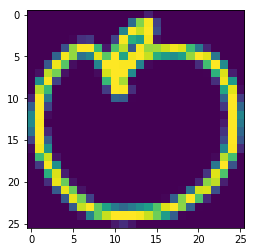

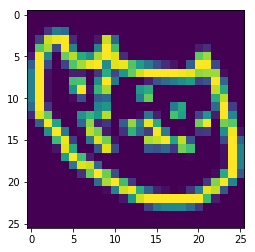

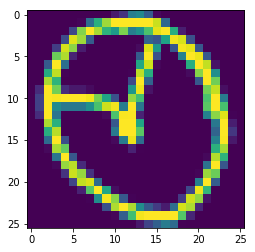

In [13]:
# locate misclassified/classified examples
count = 0
correct_ims = []
correct_ims_labels = []
# correct
while (count < 10):
    i = np.random.choice(dev_data.shape[0], size=1, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    if y == y_hat_:
        count += 1
        correct_ims.append(tempy2[i])
        correct_ims_labels.append(y)

correct_ims = np.array(correct_ims)
correct_ims = correct_ims.reshape(10, 26, 26)
for p in range(len(correct_ims)):
    plt.figure()
    plt.imshow(correct_ims[p])

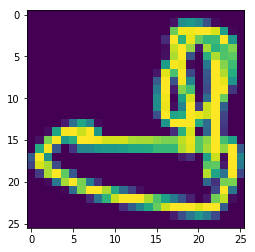

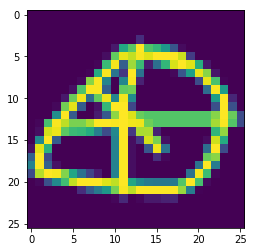

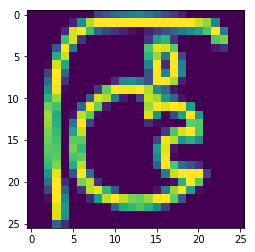

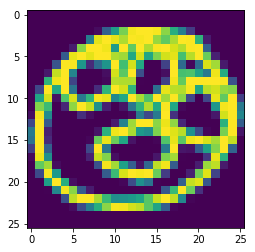

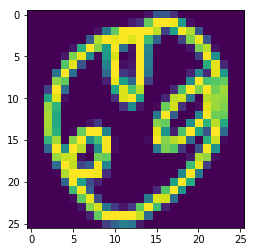

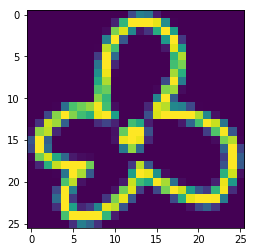

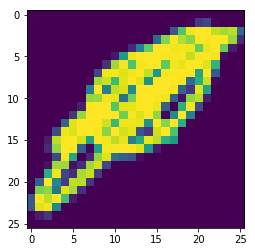

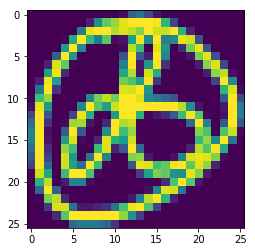

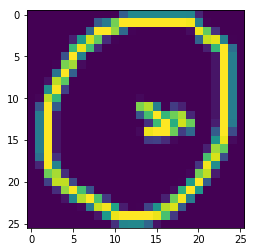

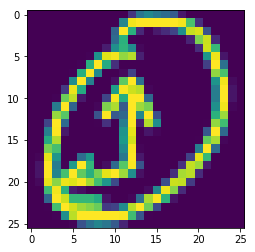

In [14]:
# incorrect images
count = 0
incorrect_ims = []
incorrect_ims_labels = []
while (count < 10):
    i = np.random.choice(dev_data.shape[0], size=1, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    if y != y_hat_:
        count += 1
        incorrect_ims.append(tempy2[i])

incorrect_ims = np.array(incorrect_ims)
incorrect_ims = incorrect_ims.reshape(10, 26, 26)
for p in range(len(incorrect_ims)):
    plt.figure()
    plt.imshow(incorrect_ims[p])

There are a few qualitative differences in the pictures. From an initial glance, it seems as though SOME of the incorrectly classified images are not very well-drawn, and do not resemble the target class very well. For example the 1st and 7th images do not really look like anything. This is different from the correctly classified examples, which are clearly defined. The misclassified examples are definitely more difficult for me to classify as a human.

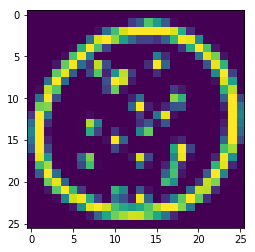

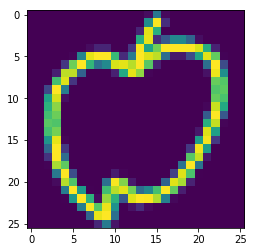

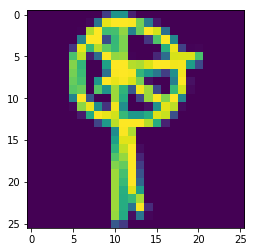

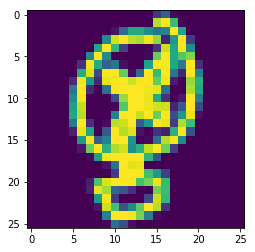

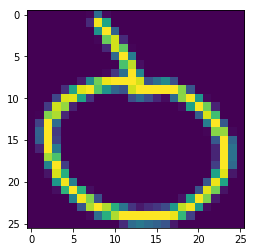

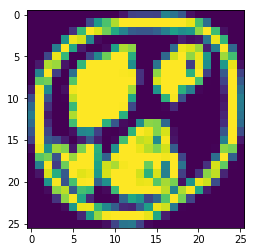

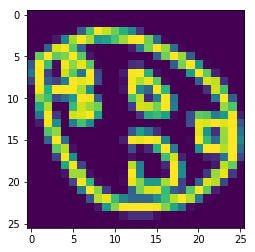

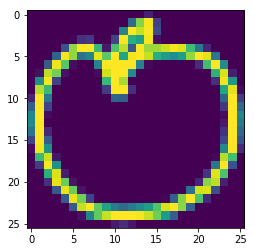

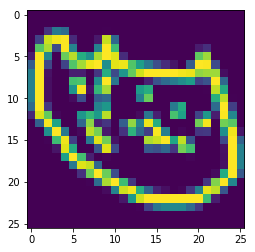

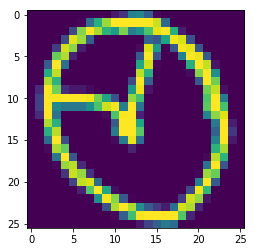

In [15]:
#add gaussian noise
from skimage import filters
ranges = []
for k in range(len(correct_ims)):
    ranges.append(np.amax(correct_ims) - np.amin(correct_ims))
    
copy_correct = correct_ims
copy_incorrect = incorrect_ims

for j in range(len(copy_correct)):
    copy_correct[j] = filters.gaussian(copy_correct[j], sigma=float(ranges[j])/10)

for p in range(len(copy_correct)):
    plt.figure()
    plt.imshow(copy_correct[p])

In [16]:
# classify perturbed images:
correct = 0
for q in range(len(copy_correct)):
    x = autograd.Variable(torch.from_numpy(copy_correct[q].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(correct_ims_labels[q].astype(np.int)))
    y_hat_ = model(x)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    if y == y_hat_:
        correct += 1

print("The accuracy is: " + str(float(correct/10)))

The accuracy is: 1.0


In the above cell, we can see that the model still correctly classifies these perturbed images

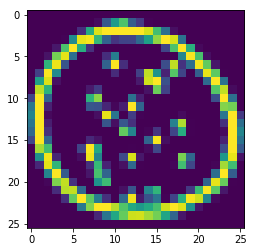

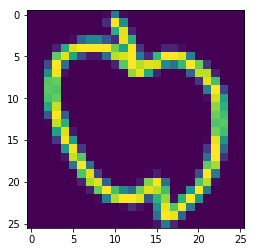

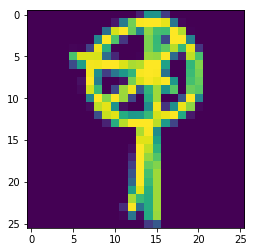

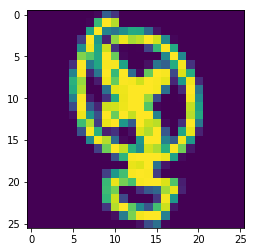

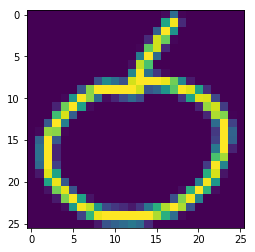

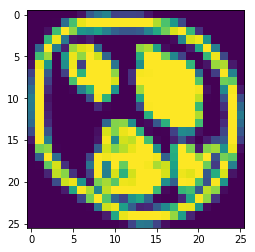

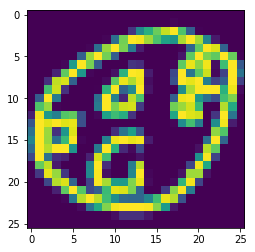

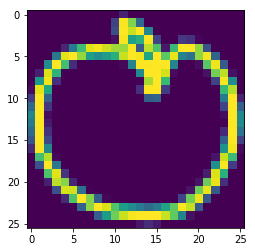

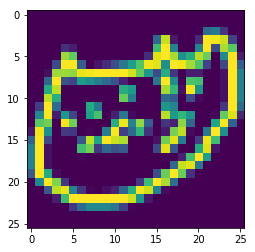

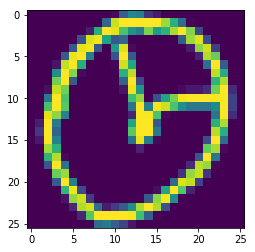

In [17]:
# flip images
other = correct_ims
for u in range(len(other)):
    other[u] = cv2.flip(other[u], 1)
    plt.figure()
    plt.imshow(other[u])

In [18]:
#classify flipped images
correct = 0
for q in range(len(other)):
    x = autograd.Variable(torch.from_numpy(other[q].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(correct_ims_labels[q].astype(np.int)))
    y_hat_ = model(x)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    if y == y_hat_:
        correct += 1

print("The accuracy is: " + str(float(correct/10)))

The accuracy is: 1.0


The classifier does classify the flipped images correctly, as is seen above. 

This "failure" is probably a real failure, since all of the image classes above look the same even if they are flipped. For example, if I were to flip a baseball or an apple, they would still look like baseballs or apples, respectively. Thus if the classifier were to classify a flipped image incorrectly, it should be considered a failure.

However, some scenarios do exist when we want to remain invariant to flipping. For example, if we are trying to train a classifier to classify only vary specific images in a certain orientation, we perhaps may not the classifier to classify a flipped image, which even though may appear very similar to the original image, is not exactly that image. For example, let's say we want to train a classifier to distinguish a human that is facing rightward versus leftward. In this case, we DO NOT want the classifier to remain invariant to flipping, since flipping an image should result in the other label. 

To ensure that our model remains robust to horizontal flipping, we could ensure that we transform some of the training data images to flip them (perhaps using opencv or some other library), so that our model is trained on some flipped images. We would have to find the right balance of flipped and not flipped images so that our model is robust to normal images and flipped images as well.

My Kaggle name is Rohan Tilva (username is rohantilva), and the submission of my kaggle file was described as "submission for rohantilva" in output.csv.